#### Import Dependencies

In [34]:
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# used as a regular expression to find patterns and process them
import re
import string
# nltk - an NLP toolkit  library, which is a widely used Python library for working with human language data.
import nltk
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer

#### Importing and inspecting the Dataset

We will be using the [sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140). It contains 1.6 tweets extracted using the Twitter API. The tweets have been annotated (0=Negative and 4=Positive) which we will use to detect sentiment.

In [16]:
# importing the dataset
DATASET_COLUMNS =["sentiment", "ids", "date", "flag", "user", "text" ]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('./Data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [17]:
df.tail()

,sentiment,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [18]:
# .T is to display the statistics horizontally rather than vertically.
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
sentiment,1600000.0,2.000000e+00,2.000001e+00,0.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,4.000000e+00
ids,1600000.0,1.998818e+09,1.935761e+08,1.467810e+09,1.956916e+09,2.002102e+09,2.177059e+09,2.329206e+09


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 4
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  object
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
dtypes: int64(1), object(4)
memory usage: 73.2+ MB


In [19]:
# Check for nulls
df.isna().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

In [20]:
df.isnull().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

Distribution of Data Count-Plot

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

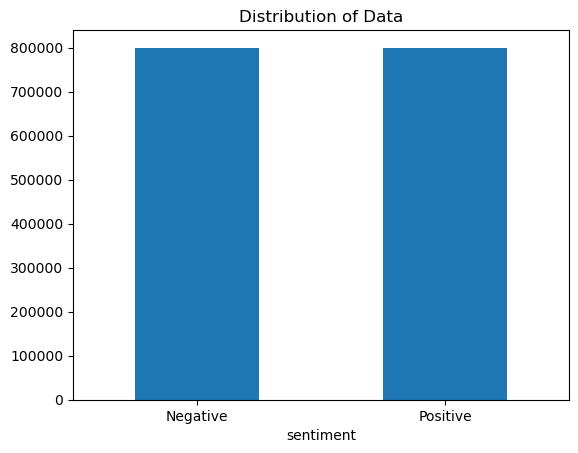

In [26]:
# Remove unnecessary columns
df = df[['sentiment', 'text']]

# replacing the value for easy understanding
df['sentiment'] = df['sentiment'].replace(4,1)

# Plottimg the distribution
df.groupby('sentiment').count().plot(kind='bar', title = 'Distribution of Data', legend=False).set_xticklabels(['Negative','Positive'], rotation=0)


There is no class imbalance

#### Text Preprocessing

This is traditionally an important step for NLP tasks. Tweets usually contain unnecessary data like user mentions, hyperlink texts, emojis and punctuations.We need to transform them into a more digestable form so that our ML algorithms can perfom better.

We will follow the follwing process while cleaning:
 - **Lower casing** - each text iks converted to lowercase
 - **Stop word handling** - These are a set of commonly used words like, "the", "is", "and" ...
 - **Removing URLs, Mentions and numbers** - We will do this using pattern detection and RegEx.
 - **Tokenizing** - Used in NLP to split paragraphs and sentences into smaller units that can be more easily assigned meaning.
 - **Stemming & Lemmatization** - These techniques are used to prepare words, texts and documents for further processing. Lemmatization takes more time because it finds meaningful word/ representation. Stemming just needs to get a base word and therefore takes less time. 

In [31]:
# Converting to lowercase

df['text'] = df['text'].str.lower()
df['text'].head(4)

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    is upset that he can't update his facebook by ...
2    @kenichan i dived many times for the ball. man...
3      my whole body feels itchy and like its on fire 
Name: text, dtype: object

In [32]:
# Stop word handling

StopWordsList = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

# removing Stopwords
StopWords = set(StopWordsList)
def stopwords_handler(text):
    return " ".join([word for word in str(text).split() if word not in StopWords])

df['text'] = df['text'].apply(lambda text: stopwords_handler(text))
df['text'].head(4)



0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
Name: text, dtype: object

In [36]:
# Removing stopwords using nltk lib

# Tokenizing of text
tokenizer = ToktokTokenizer()

# Setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')

# removing standard english stopwords like prepositions, adverbs ...
stopw = set(stopwords.words('english'))
print('NLTK stop words list \n')
print(stopw)

# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case: 
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text    

NLTK stop words list 

{'out', "you've", 'above', 'during', 's', "you'll", 'both', 'nor', 'do', "should've", 'his', 'after', "mustn't", 'm', 'to', 'is', 'by', 'there', 'at', 'any', 'the', 'off', 'ours', 'and', 'yourselves', 'i', 'over', 'does', "couldn't", 'weren', 'he', 'about', 'more', 'why', 'how', 'too', 'we', "that'll", 'd', 'this', 'which', 're', 'hadn', 'itself', "shouldn't", "hadn't", 'other', 't', "don't", "shan't", 'mustn', 'because', 'not', 'she', 'have', "aren't", 'what', 'a', 'doesn', 'whom', 'himself', 'yourself', 'these', 'through', 'then', 'did', 'few', 'their', 'were', 'so', 'hasn', 'they', 'no', "wouldn't", 'it', 'y', 'that', 'under', 'on', 'being', 'my', "doesn't", 'while', 'down', 'him', 'will', 'but', 'couldn', 'hers', "needn't", 'once', 'in', 'are', 'our', 'ain', 'needn', 'again', 'o', 'theirs', 'your', 'who', 'didn', 'below', 'her', 'same', 'isn', 'if', 'for', 'wasn', 'wouldn', "she's", 'ourselves', 'own', 'when', 'ma', 'me', "won't", 'yours', 'am', 'll', "haven'

In [37]:
df['text'] = df['text'].apply(remove_stopwords)
df['text'].tail()

1599995                    woke up. school best feeling ever
1599996    thewdb.com - cool hear old walt interviews ! â...
1599997                    ready mojo makeover ? ask details
1599998    happy 38th birthday boo alll time ! ! ! tupac ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, dtype: object

In [41]:
# removing URLs

def clean_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', data)

df['text'] = df['text'].apply(lambda x: clean_URLs(x))
df['text'].head()

0    @switchfoot  shoulda got david carr third day ...
1    upset ' update facebook texting ... might cry ...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass , ' behaving all. ' mad. ? ' ...
Name: text, dtype: object

In [43]:
# Removing numbers

def clean_numbers(data):
    return re.sub('[0-9]+', '', data)

df['text'] = df['text'].apply(lambda x: clean_numbers(x))
df['text'].head()

0    @switchfoot  shoulda got david carr third day ...
1    upset ' update facebook texting ... might cry ...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass , ' behaving all. ' mad. ? ' ...
Name: text, dtype: object

In [44]:
# Remove patterns

def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for word in r:
        input_text = re.sub(word, "", input_text)
    return input_text

In [45]:
# remove twitter handles (mentions)

df['text'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

df.head()

,sentiment,text
0,0,shoulda got david carr third day it. ;
1,0,upset ' update facebook texting ... might cry ...
2,0,dived many times ball. managed save % rest g...
3,0,whole body feels itchy like fire
4,0,", ' behaving all. ' mad. ? ' see ."


In [47]:
# remove special characters and punctuations

df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_14100\2802942518.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")


,sentiment,text
0,0,shoulda got david carr third day it
1,0,upset update facebook texting might cry ...
2,0,dived many times ball managed save rest g...
3,0,whole body feels itchy like fire
4,0,behaving all mad see


In [50]:
# remove short words

df['text'] = df['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
df.head()

,sentiment,text
0,0,shoulda david carr third
1,0,upset update facebook texting might result sch...
2,0,dived many times ball managed save rest bounds
3,0,whole body feels itchy like fire
4,0,behaving


In [51]:
# Tokenizing the text
tokenizerr = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizerr.tokenize)
df['text'].head()

0                        [shoulda, david, carr, third]
1    [upset, update, facebook, texting, might, resu...
2    [dived, many, times, ball, managed, save, rest...
3              [whole, body, feels, itchy, like, fire]
4                                           [behaving]
Name: text, dtype: object

In [52]:
# Applying Stemming

st = nltk.PorterStemmer()
def text_stemming(data):
    text = [st.stem(word) for word in data]
    return data
df['text'] = df['text'].apply(lambda x: text_stemming(x))
df['text'].head()

0                        [shoulda, david, carr, third]
1    [upset, update, facebook, texting, might, resu...
2    [dived, many, times, ball, managed, save, rest...
3              [whole, body, feels, itchy, like, fire]
4                                           [behaving]
Name: text, dtype: object

In [53]:
# Applying Lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')

lm = nltk.WordNetLemmatizer()
def text_lemmatizer(data):
    text = [lm.lemmatize(word) for word in data]
    return ' '.join(text)
df['text'] = df['text'].apply(lambda x: text_lemmatizer(x))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


,sentiment,text
0,0,shoulda david carr third
1,0,upset update facebook texting might result sch...
2,0,dived many time ball managed save rest bound
3,0,whole body feel itchy like fire
4,0,behaving
